### **Sentimen Analisis Untuk Aplikasi Playstore (Studi Kasus GoPay)**

# **PERSIAPAN**

In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import joblib
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Memuat dan Membersihkan Data**

In [2]:
# Memuat data ulasan dari file CSV
csv_file_path = '/content/drive/My Drive/Colab Notebooks/SUBMISION/gopayreviews.csv'
df = pd.read_csv(csv_file_path)

# Menampilkan informasi ringkas tentang DataFrame
df.info()

# Membersihkan teks ulasan
def clean_text(text):
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Menghapus kata dengan 1-2 huruf
    text = re.sub(r'[^a-zA-Z\s]', '', text)   # Menghapus karakter non-alfabet
    text = text.lower()                       # Mengubah menjadi huruf kecil
    return text

df['cleaned_content'] = df['content'].apply(clean_text)

# Melabeli data berdasarkan skor
def label_sentiment(score):
    if score >= 4:
        return 'positif'
    elif score == 3:
        return 'netral'
    else:
        return 'negatif'

df['label'] = df['score'].apply(label_sentiment)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

# Tokenizing dan Padding untuk model LSTM, CNN, GRU, BiLSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_content'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_content'])
X_padded = pad_sequences(X_seq, maxlen=100)

# Membagi data menjadi training dan testing set
X_train_padded, X_test_padded, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12500 non-null  object
 1   userName              12500 non-null  object
 2   userImage             12500 non-null  object
 3   content               12500 non-null  object
 4   score                 12500 non-null  int64 
 5   thumbsUpCount         12500 non-null  int64 
 6   reviewCreatedVersion  10224 non-null  object
 7   at                    12500 non-null  object
 8   replyContent          1575 non-null   object
 9   repliedAt             1575 non-null   object
 10  appVersion            10224 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.0+ MB


In [3]:
# Tampilkan sample Baris Data
df.head()

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")
/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,cleaned_content,label
0,d49949da-d9a7-400c-93c1-a73b4e491686,Agoez Ahmad,https://play-lh.googleusercontent.com/a-/ALV-U...,Mantap dan Ok Banget ❤️👍🫰,5,0,NaN,2024-08-09 14:28:37,NaN,NaN,NaN,mantap dan banget,positif
1,e9c9d00e-55a4-41c8-a257-387afea1bb55,Kurnia Wandi,https://play-lh.googleusercontent.com/a/ACg8oc...,Praktis dan cepat,5,0,1.28.0,2024-08-09 14:27:33,NaN,NaN,1.28.0,praktis dan cepat,positif
2,f793671b-e5b3-4a38-837a-8da3faf43278,Irwan Saputra,https://play-lh.googleusercontent.com/a/ACg8oc...,Lebih canggih dan aman,5,0,1.27.0,2024-08-09 14:27:01,NaN,NaN,1.27.0,lebih canggih dan aman,positif
3,4d0a7c51-afa8-4671-ae27-cd4e37913539,Idris Copler,https://play-lh.googleusercontent.com/a-/ALV-U...,Makjoss,5,0,1.28.0,2024-08-09 14:26:24,NaN,NaN,1.28.0,makjoss,positif
4,b25d5649-5f8e-42fe-bd72-f003dddf366b,Ade Rusrika,https://play-lh.googleusercontent.com/a/ACg8oc...,Mantap gopay,5,0,1.28.0,2024-08-09 14:24:18,NaN,NaN,1.28.0,mantap gopay,positif


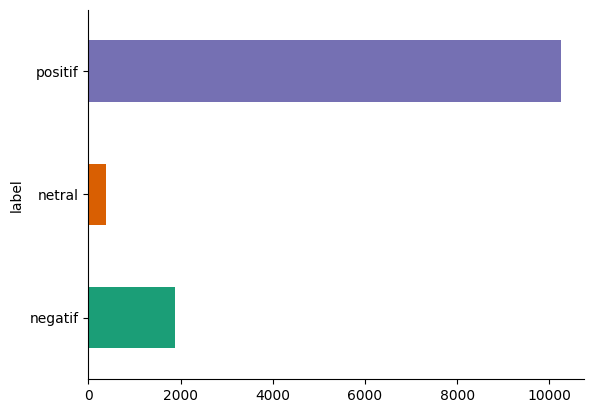

In [4]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## **Membuat Model**

In [5]:
#Model LSTM
embedding_dim = 100

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(3, activation='softmax'))

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lstm_history = lstm_model.fit(X_train_padded, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

_, lstm_accuracy = lstm_model.evaluate(X_test_padded, y_test)
print(f'LSTM Accuracy: {lstm_accuracy * 100:.2f}%')


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 366ms/step - accuracy: 0.8035 - loss: 0.5681 - val_accuracy: 0.8670 - val_loss: 0.3759
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 208ms/step - accuracy: 0.8975 - loss: 0.3109 - val_accuracy: 0.8975 - val_loss: 0.3203
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.9176 - loss: 0.2696 - val_accuracy: 0.9035 - val_loss: 0.3153
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 218ms/step - accuracy: 0.9318 - loss: 0.2309 - val_accuracy: 0.9020 - val_loss: 0.3226
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 230ms/step - accuracy: 0.9428 - loss: 0.1920 - val_accuracy: 0.8980 - val_loss: 0.3383
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 195ms/step - accuracy: 0.9504 - loss: 0.1723 - val_accuracy: 0.8985 - val_loss: 0.3546
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8961 - loss: 0.3362
LSTM Accuracy: 90.08%


In [6]:
#Model CNN
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100))
cnn_model.add(Conv1D(128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(3, activation='softmax'))

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train_padded, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

_, cnn_accuracy = cnn_model.evaluate(X_test_padded, y_test)
print(f'CNN Accuracy: {cnn_accuracy * 100:.2f}%')


Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.8410 - loss: 0.5281 - val_accuracy: 0.8965 - val_loss: 0.3293
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9059 - loss: 0.2937 - val_accuracy: 0.8950 - val_loss: 0.3246
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.9311 - loss: 0.2304 - val_accuracy: 0.8945 - val_loss: 0.3430
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8917 - loss: 0.3437
CNN Accuracy: 90.04%


In [7]:
#Model Gru
gru_model = Sequential()
gru_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100))
gru_model.add(SpatialDropout1D(0.2))
gru_model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
gru_model.add(Dense(3, activation='softmax'))

gru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

gru_history = gru_model.fit(X_train_padded, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

_, gru_accuracy = gru_model.evaluate(X_test_padded, y_test)
print(f'GRU Accuracy: {gru_accuracy * 100:.2f}%')


Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 242ms/step - accuracy: 0.7962 - loss: 31.8769 - val_accuracy: 0.8215 - val_loss: 0.6039
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 238ms/step - accuracy: 0.8363 - loss: 0.4923 - val_accuracy: 0.8440 - val_loss: 0.4562
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 247ms/step - accuracy: 0.8647 - loss: 0.3868 - val_accuracy: 0.8715 - val_loss: 0.4083
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8409 - loss: 0.5917
GRU Accuracy: 83.36%


In [8]:
#Model BiLSTM
bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100))
bilstm_model.add(SpatialDropout1D(0.2))
bilstm_model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
bilstm_model.add(Dense(3, activation='softmax'))

bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

bilstm_history = bilstm_model.fit(X_train_padded, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

_, bilstm_accuracy = bilstm_model.evaluate(X_test_padded, y_test)
print(f'BiLSTM Accuracy: {bilstm_accuracy * 100:.2f}%')


Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 388ms/step - accuracy: 0.8123 - loss: 0.5441 - val_accuracy: 0.8795 - val_loss: 0.3517
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 396ms/step - accuracy: 0.8992 - loss: 0.3268 - val_accuracy: 0.8880 - val_loss: 0.3335
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 395ms/step - accuracy: 0.9144 - loss: 0.2730 - val_accuracy: 0.9060 - val_loss: 0.3144
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 390ms/step - accuracy: 0.9351 - loss: 0.2197 - val_accuracy: 0.9005 - val_loss: 0.3246
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 387ms/step - accuracy: 0.9403 - loss: 0.2019 - val_accuracy: 0.8965 - val_loss: 0.3551
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 404ms/step - accuracy: 0.9469 - loss: 0.1747 - val_accuracy: 0.8955 - val_loss: 0.3627
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8932 - loss: 0.3276
BiLSTM Accuracy: 90.16%


**Evaluasi dan Pemilihan Model Terbaik**

In [9]:
# Menampilkan akurasi semua model
print(f'LSTM Accuracy: {lstm_accuracy * 100:.2f}%')
print(f'CNN Accuracy: {cnn_accuracy * 100:.2f}%')
print(f'GRU Accuracy: {gru_accuracy * 100:.2f}%')
print(f'BiLSTM Accuracy: {bilstm_accuracy * 100:.2f}%')

# Memilih model terbaik
best_accuracy = max(lstm_accuracy, cnn_accuracy, gru_accuracy, bilstm_accuracy)
if best_accuracy >= 0.85:
    print(f"Model terbaik dengan akurasi {best_accuracy * 100:.2f}%")
else:
    print("Tidak ada model yang mencapai akurasi 85%")


LSTM Accuracy: 90.08%
CNN Accuracy: 90.04%
GRU Accuracy: 83.36%
BiLSTM Accuracy: 90.16%
Model terbaik dengan akurasi 90.16%


In [10]:
#Menyimpan Model Terbaik
if best_accuracy == lstm_accuracy:
    lstm_model.save('/content/drive/My Drive/Colab Notebooks/DICODING/Intermediate/lstm_model.h5')
elif best_accuracy == cnn_accuracy:
    cnn_model.save('/content/drive/My Drive/Colab Notebooks/DICODING/Intermediate/cnn_model.h5')
elif best_accuracy == gru_accuracy:
    gru_model.save('/content/drive/My Drive/Colab Notebooks/DICODING/Intermediate/gru_model.h5')
elif best_accuracy == bilstm_accuracy:
    bilstm_model.save('/content/drive/My Drive/Colab Notebooks/DICODING/Intermediate/bilstm_model.h5')


In [11]:
# Menghasilkan requirements.txt
!pip freeze > requirements.txt

# Mengunduh requirements.txt
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>